In [1]:
import json
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib widget

In [2]:
# load camera positions
campos_dict = {}
camrot_dict = {}
focal_dict = {}
princpt_dict = {}
for split in ("train", "test", "val"):
    with open(f"../../data/InterHand2.6M_30fps/annotations/{split}/InterHand2.6M_{split}_camera.json") as f:
        cameras = json.load(f)
    capture_id = "0"
    for item in ("campos", "camrot", "focal", "princpt"):
        for cam_id in cameras[capture_id][item].keys():
            item_var = np.array(cameras[capture_id][item][cam_id], dtype=np.float32)
            item_dict_var = eval(item + "_dict")
            if cam_id not in item_dict_var:
                item_dict_var[cam_id] = item_var
test_cam = "400008"
test_cam_pos = np.array(campos_dict[test_cam], dtype=np.float32).reshape(3)
test_cam_rot = np.array(camrot_dict[test_cam], dtype=np.float32).reshape(3, 3)

In [3]:
# load image data
# split = "train"
# with open(f"../../data/InterHand2.6M_30fps/annotations/{split}/InterHand2.6M_{split}_data.json") as f:
#     data = json.load(f)
# images = data["images"]
# del data
# test_data = list(
#     filter(
#         lambda image: image["capture"] == 0
#         and image["seq_name"] == "0000_neutral_relaxed"
#         and image["frame_idx"] == 563,
#         images,
#     )
# )
# json.dump(test_data, open("test_data.json", "w"))
test_data=json.load(open("test_data.json", "r"))

In [4]:
# load joint 3D
split = "train"
with open(f"../../data/InterHand2.6M_30fps/annotations/{split}/InterHand2.6M_{split}_joint_3d.json") as f:
    joint = json.load(f)
test_joint_valid = joint["0"]["563"]["joint_valid"]
test_joint = []
for i, j in enumerate(joint["0"]["563"]["world_coord"]):
    if test_joint_valid[i][0] == 1.0:
        test_joint.append(j)
del joint
test_joint = np.array(test_joint, dtype=np.float32).reshape(-1, 3)

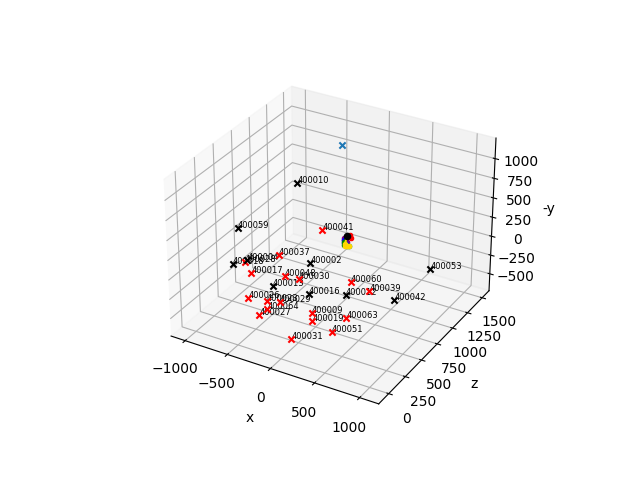

In [5]:
# plot camera positions
plt.close("all")
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_zlabel("-y")

with open("test_data.json") as f:
    test_data = json.load(f)
# test_camera = set(map(lambda x: x["camera"], test_data))
views_28 = ["400002", "400004", "400009", "400010", "400012", "400013", "400016", "400017", "400018", "400019",
            "400023", "400026", "400027", "400028", "400029", "400030", "400031", "400037", "400039", "400041",
            "400042", "400048", "400051", "400053", "400059", "400060", "400063", "400064"]
views_10 = ["400002", "400004", "400010", "400012", "400013", "400016", "400018", "400053", "400042", "400059"]

# plot camera
for i, k in enumerate(campos_dict.keys()):
    if k in views_28:
        color = "black" if k in views_10 else "red"
        ax.scatter(campos_dict[k][0], campos_dict[k][2], -campos_dict[k][1], marker="x", color=color)
        ax.text(campos_dict[k][0], campos_dict[k][2], -campos_dict[k][1], k, size=6)
ax.scatter(test_cam_pos[0], test_cam_pos[2], -test_cam_pos[1], marker="x")

# plot joint points
def plot_joint(joint, ax):
    # for point_id, point in enumerate(test_joint):
    #     ax.scatter(point[0], point[2], -point[1], color="black", marker="o")
    # ax.text(point[0], point[2], -point[1], point_id)
    C = ["red", "purple", "blue", "green", "gold", "black"]
    for i, r in enumerate([np.arange(0, 4), np.arange(4, 8), np.arange(8, 12), np.arange(12, 16), np.arange(16, 20)]):
        r_ = np.append(r, -1)
        ax.plot(xs=joint[r_, 0], ys=joint[r_, 2], zs=-joint[r_, 1], color=C[i], marker="o", markersize=3)
    ax.scatter(joint[-1, 0], joint[-1, 2], -joint[-1, 1], color=C[-1], marker="o", s=20)


plot_joint(test_joint, ax)
plt.show()

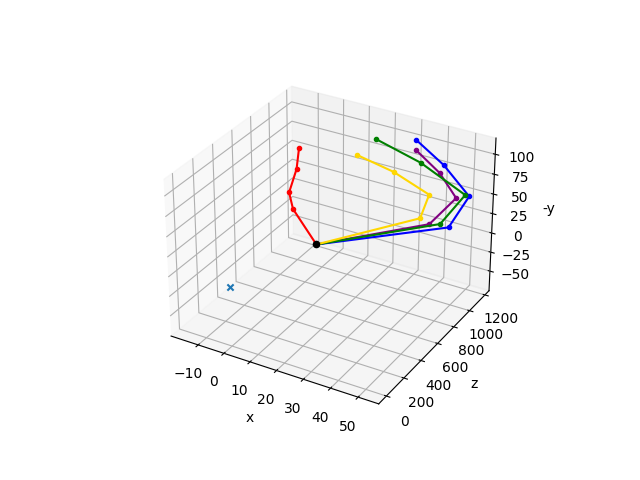

In [6]:
def world2cam(world_coord, cam_pos, cam_rot) -> np.ndarray:
    """
    cam_coord follows COLMAP coordinate system: [right, down, forwards]
    https://github.com/facebookresearch/InterHand2.6M/blob/main/tool/MANO_world_to_camera/convert.py#L64

    :param world_coord: N,3 world coordinates
    :param cam_pos: world coordinates of camera
    :param cam_rot: 3*3 world to camera rotation
    """
    world_coord = world_coord.reshape(-1, 3)
    t = -np.dot(cam_rot, cam_pos.reshape(3, 1)).reshape(3)
    # apply camera extrinsic to convert world coordinates to camera coordinates
    cam_coord = np.dot(cam_rot, world_coord.transpose(1, 0)).transpose(1, 0) + t.reshape(1, 3)
    # return cam_coord
    # another method
    # T_world2cam = np.append(cam_rot, t.reshape(3, 1), axis=1)
    # world_coord_extended = np.concatenate([world_coord, np.ones([world_coord.shape[0], 1])], axis=1)
    # cam_coord = np.dot(T_world2cam, world_coord_extended.transpose(1, 0)).transpose(1, 0)
    return cam_coord


def cam2world(cam_coord, cam_pos, cam_rot) -> np.ndarray:
    """
    :param cam_coord: N,3 camera coordinates
    :param cam_pos: world coordinates of camera
    :param cam_rot: 3*3 world to camera rotation
    """
    cam_coord = cam_coord.reshape(-1, 3)
    t = -np.dot(cam_rot, cam_pos.reshape(3, 1)).reshape(3)
    # apply camera extrinsic to convert world coordinates to camera coordinates
    world_coord = np.dot(np.linalg.inv(cam_rot), cam_coord.transpose(1, 0) - t.reshape(3, 1)).transpose(1, 0)
    return world_coord


def get_T_cam2world(cam_pos, cam_rot) -> np.ndarray:
    """
    :param cam_pos: world coordinates of camera
    :param cam_rot: 3*3 world to camera rotation
    """
    T_cam2world = np.append(np.linalg.inv(cam_rot), cam_pos.reshape(3, 1), axis=1)
    return T_cam2world


fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111, projection="3d")
ax2.set_xlabel("x")
ax2.set_ylabel("z")
ax2.set_zlabel("-y")

test_cam_pos_cam = world2cam(test_cam_pos, test_cam_pos, test_cam_rot).squeeze()
ax2.scatter(test_cam_pos_cam[0], test_cam_pos_cam[2], -test_cam_pos_cam[1], marker="x")

test_joint_cam = world2cam(test_joint, test_cam_pos, test_cam_rot)
plot_joint(test_joint_cam, ax2)
plt.show()

In [7]:
# Test: outputs should be the same
test_pos = np.array([1, 2, 3])
print(test_pos)

test_pos_cam = world2cam(test_pos, test_cam_pos, test_cam_rot)
print(cam2world(test_pos_cam, test_cam_pos, test_cam_rot))

T_cam2world = get_T_cam2world(test_cam_pos, test_cam_rot)
camera_coord_extended = np.concatenate([test_pos_cam, np.ones([test_pos_cam.shape[0], 1])], axis=1)
print(np.dot(T_cam2world, camera_coord_extended.transpose(1, 0)).transpose(1, 0))

[1 2 3]
[[1.00000004 2.00000005 3.00000001]]
[[1.00000171 1.99998192 2.99998945]]
